### k-Nächste Nachbarn Verfahren auf DMC 2010 Daten

#### Versionsgeschichte
- 1.0 05.10.2022 Willi Hahn Initialversion
- 1.1 07.10.2022 Willi Hahn Korrektur und label in der confusion matrix. Berechnung TP, FP, TN, FN.  
Korrektur pd.set_option statt pd.option_context für Anzeige aller Spalten eines data frame.
k-NN Modellbildung parametrisiert.
Berechnung der Umsatzsteigerung auf alle Trainings- und Testdaten, nicht nur auf den Tetstanteil. 
Alternative Blöcke für die Datenvorbereitung eingeführt.    
- 1.2 16.11.2022 Willi Hahn Zelle Wahrheitsmatrix mit Ausgabe TPR, FPR, RNR, FNR,
Plot, Spezifität.
- 1.3 27.11.2022 Willi Hahn Int64 wird zu int64 in Zelle Datenvorbereitung:
df['DaysDeliveryPromised'] = ((df['deliverydatereal'] - df['deliverydatepromised']).dt.days).astype('int64'), 
damit funktioniert auch der Balancer SMOTE
- 1.4 06.12.2022 Willi Hahn Zelle Export Evaluierungsdaten angefügt.
one hot encoding von advertisingcode abgeglichen zwischen Train- und Evaldaten.


In [9]:
# !pip install -U imbalanced-learn  # einmalig installieren

# notwendige Bibliotheken importieren und Verbesserung der Laufzeitkonfiguration
import pandas as pd
import numpy as np
from collections import Counter
_ = pd.set_option('display.max_columns', None) # damit mehr als 20 Spalten angezeigt werden.
#                                                    _ =  damit Objektausgabe unterdrückt wird.
pd.set_option('display.min_rows', 15) # damit nicht nur 10 Zeilen mit  ... dazwischen ausgegeben werden
pd.set_option('display.max_rows', 500) # damit nicht nur 10 Zeilen mit  ... dazwischen ausgegeben werden
import seaborn as sns #importing Seaborn's for plots
from sklearn import metrics as met 
import matplotlib.pyplot as plt #Plot Bibliothek
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier



In [10]:
# Daten für Training einLesen 

#path = 'c:/myBox/Projekte/FHDW/Kurs DAML/python/dmc2010_train.txt' # für lokale Dateien
path = 'https://raw.githubusercontent.com/FHDW-DAML/22Q4/main/dmc2010_train.txt'  # für Colab

# Modellierung der Evaluierungsdaten
#path = 'c:/myBox/Projekte/FHDW/Kurs DAML/python/dmc2010_class.txt' # für lokale Dateien
#path = 'https://raw.githubusercontent.com/FHDW-DAML/22Q4/main/dmc2010_class.txt'  # für Colab

# Modellierung der Evaluierungs und Realdaten
#path = 'c:/myBox/Projekte/FHDW/Kurs DAML/python/DMC2010_class_real_zusammen.txt' # für lokale Dateien
#path = 'https://raw.githubusercontent.com/FHDW-DAML/22Q4/main/DMC2010_class_real_zusammen.txt'  # für Colab

num_cols = ['numberitems', 'weight', 'remi', 'cancel', 'used', 'w0', 'w1',
                'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9', 'w10']
date_cols = ['date', 'datecreated', 'deliverydatepromised', 'deliverydatereal']
target_col = 'target90'

df = pd.read_csv(path, sep=';', index_col='customernumber', parse_dates=date_cols, low_memory=False)

#df.info()




In [11]:
# Datenvorbereitung für den ersten Durchstich zum ersten Modell : 
#     brutal und löschen was zu Fehlern bei der Modellbildung führt

print ("Alle Spalten mit Nulls Werte im data frame löschen wir, damit das k-nächste Nachbarn Verfahren arbeiten kann.")
df.drop(columns=['advertisingdatacode', 'delivpostcode'], inplace=True, axis=1)
print ("Alle Datumsfelder im data frame löschen wir, damit das k-nächste Nachbarn Verfahren arbeiten kann.")
df.drop(columns=date_cols, inplace=True, axis=1)


Alle Spalten mit Nulls Werte im data frame löschen wir, damit das k-nächste Nachbarn Verfahren arbeiten kann.
Alle Datumsfelder im data frame löschen wir, damit das k-nächste Nachbarn Verfahren arbeiten kann.


In [12]:
# Trainings- und Testdaten aufteilen

TESTANTEIL=0.25

#df.info()

# Trennung von unabhängigen Variablen und abhängiger Zielvariable
y = df['target90']
x = df.drop(['target90'], axis = 1)
#x.head().T
#y.head().T
classratio = y.sum() / y.count()
x_columns = x.columns

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=TESTANTEIL, random_state=42)

# und prüfen durch ansehen
#print (x_train.shape)
#print (y_train.shape)
#print (x_test.shape)
#print (y_test.shape)
#x_test.info()
#x_train.head().T
#y_train.head().T

print('\nKlassenverhältnis target90 TRAIN: %.3f' % (y_train.sum() / y_train.count()),\
      '\nKlassenverhältnis target90 TEST:  %.3f' % (y_test.sum() / y_test.count()),\
      '\nKlassenverhältnis target90 Gesamt:  %.3f' % classratio)




Klassenverhältnis target90 TRAIN: 0.187 
Klassenverhältnis target90 TEST:  0.185 
Klassenverhältnis target90 Gesamt:  0.187


In [13]:
## Modelltraining
#
# Parameter nach https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

K_PARAM = 17 # Anzahl Nachbarn für die k-NN Vorhersage
METRIC = 'euclidean' # cosine oder euclidean Metrik für die Abstandsberechnung der Nachbarn
N_JOBS=-1 # int, default=None, -1 means using all processors.
WEIGHTS='uniform' # weights{‘uniform’, ‘distance’} or callable, default=’uniform’

classifier = KNeighborsClassifier(n_neighbors=K_PARAM, metric=METRIC, n_jobs=N_JOBS, weights=WEIGHTS)
classifier.fit(x_train, y_train)
y_predtest = classifier.predict(x_test)
y_predtrain = classifier.predict(x_train)





Hyperparameter k = 17
Testdatenanteil= 0.25
Abstandsmetrik = euclidean

TP:TN:FP:FN = 7:6595:13:1492
Genauigkeit = 0.81
Recall = 0.00
Präzision = 0.35
F1 Wert = 0.01
Speziftät = 1.00
TPR = 0.35
FPR = 0.00
TNR = 0.82
FNR = 74.60

Umsatzsteigerung für die Testdaten = 2432.50 €
Umsatzsteigerung für hochgerechnet für alle Testdaten = 9730.00 €

Umsatzsteigerung für baseline (Gutschein an Alle) = 9310.50 €


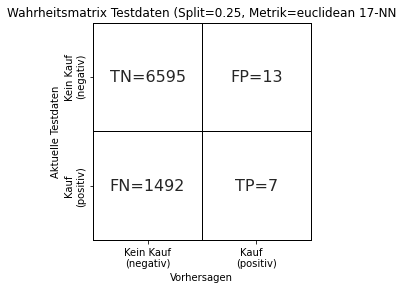

In [14]:
# Wahrheitsmatrix und Maßzahlen der Vorhersage untersuchen

# Adding classes names for better interpretation
classes_names = ['Kein Kauf\n(negativ)','Kauf   \n(positiv)']
cm = met.confusion_matrix(y_test, y_predtest);
cmdf = pd.DataFrame(cm, columns=classes_names, index = classes_names); # data frame bilden
tn, fp, fn, tp = cm.ravel();

# Seaborn's heatmap to visualize the confusion matrix
sns.heatmap(data=cmdf, cmap='gray_r', vmin=0, vmax=0,
                 annot=[[f"TN={tn:.0f}", f"FP={fp:.0f}"], [f"FN={fn:.0f}", f"TP={tp:.0f}"]],
                 linewidths=0.5, linecolor='k',  # draw black grid lines
                 clip_on=False,                  # inhibits clipping of right and lower square lines
                 fmt='', annot_kws={'fontsize': 16}, cbar=False, square=True);

plt.title("Wahrheitsmatrix Testdaten (Split="+str(TESTANTEIL)+", Metrik="+ METRIC + " "+str(K_PARAM)+"-NN");
plt.ylabel('Aktuelle Testdaten');
plt.xlabel('Vorhersagen');

print("\nHyperparameter k = "+str(K_PARAM))
print("Testdatenanteil= "+str(TESTANTEIL))
print("Abstandsmetrik = "+str(METRIC))
print ("\nTP:TN:FP:FN = " + str (tp) +":" + str (tn) +":" + str (fp) +":" + str (fn) )
print ("Genauigkeit = {:.2f}".format(met.accuracy_score(y_test, y_predtest)))
print ("Recall = {:.2f}".format(met.recall_score(y_test, y_predtest, average='binary')))
print ("Präzision = {:.2f}".format(met.precision_score(y_test, y_predtest, average='binary')))
print ("F1 Wert = {:.2f}".format(met.f1_score(y_test, y_predtest, average='binary')))
print ("Speziftät = {:.2f}".format(tn /(tn+fp)))
print ("TPR = {:.2f}".format(tp /(tp+fp)))
print ("FPR = {:.2f}".format(fp /(tn+fn)))
print ("TNR = {:.2f}".format(tn /(tn+fn)))
print ("FNR = {:.2f}".format(fn /(tp+fp)))

print ("\nUmsatzsteigerung für die Testdaten = {:.2f}".format(1.5*tn - 5.0*fn)+" €")
print ("Umsatzsteigerung für hochgerechnet für alle Testdaten = {:.2f}".format((1.5*tn - 5.0*fn) * (1/TESTANTEIL) ) +" €")
print ("\nUmsatzsteigerung für baseline (Gutschein an Alle) = {:.2f}".format((df.shape[0] * (1-classratio) * 1.5) -\
                                                                           (df.shape[0] * classratio * 5)) +" €")



#Vergleich train test https://code.themlsbook.com/chapter2/knn.html